For this assignment, I will study Male Pattern Hair Loss, also called baldness or, more technically, alopecia. 

To do this, I will first try to find some candidates from Scratch (to illustrate the process) and then show what to do if there is already a better candidate (finasteride) whith selective inhibiting capabilities and a good $IC_{50}$ we would like to make as small as possible. In short:

1. Finding good candidates using ENSEMBL from Scratch
    * Finding targets for our selected protein
    * Checking for similar molecules
2. Check for already approved drugs
3. Using Swissim and metrics to find finasteride-similar drugs

## Finding good candidates using ENSEMBL from Scratch

### Finding targets for our selected protein

In [1]:
# First, we import the necessary modules
import json  # lets us work with the json format
import requests  # allows Python to make web requests
import pandas as pd # analysis of tabular data
import numpy as np # numerical library

With a simple search, we can find the CHEMBL codes for **human** 5-alpha-reductase: [CHEMBL2363075](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL2363075/) for the whole family, and [CHEMBL1856](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL1856/) for type II, which is the one we want to target, as specified in the report. We can then proceed to search for assay data:

In [2]:
#We specify we want at least 150 compounds that target CHEMBL1856
activity_url = "https://www.ebi.ac.uk/chembl/api/data/activity?target_chembl_id_exact=CHEMBL1856&offset=150&limit=150"
activity_request = requests.get(activity_url, headers={"Accept":"application/json"}).json()

In [3]:
activity_table = pd.DataFrame.from_dict(activity_request['activities'])[['molecule_chembl_id', 'type', 'standard_value', 'standard_units']]
activity_table #And we transform the data into a table

,molecule_chembl_id,type,standard_value,standard_units
0,CHEMBL175414,Solubility,172900.0,ug.mL-1
1,CHEMBL307157,MP,45.0,%
2,CHEMBL307157,MP,0.0,%
3,CHEMBL307157,DP,0.0,%
4,CHEMBL307157,TP,76.0,%
...,...,...,...,...
145,CHEMBL336532,CAR,1.0,MPK
146,CHEMBL290133,IC50,20000.0,nM
147,CHEMBL290133,Intrinsic activity,0.32,None
148,CHEMBL296415,IC50,0.00086,ug.mL-1


In [4]:
#We select only those that have IC50
activity_table_filter = activity_table.loc[activity_table['type']=="IC50"].copy().dropna()
#Transform the standard_value column to float to be able to work with it
activity_table_filter['standard_value'] = activity_table_filter['standard_value'].astype("float")
#And we order the table by value
activity_table_filter.sort_values(['standard_value']).head(10)

,molecule_chembl_id,type,standard_value,standard_units
148,CHEMBL296415,IC50,0.00086,ug.mL-1
139,CHEMBL54768,IC50,0.01000,ug.mL-1
122,CHEMBL345415,IC50,1.07000,nM
111,CHEMBL431940,IC50,3.00000,nM
114,CHEMBL140442,IC50,3.40000,nM
92,CHEMBL129,IC50,4.00000,nM
89,CHEMBL129,IC50,4.00000,nM
91,CHEMBL129,IC50,6.00000,nM
108,CHEMBL415967,IC50,6.90000,nM
75,CHEMBL21222,IC50,10.00000,nM


When we sort the found compounds by increasing $IC_{50}$ values, we found that the best compounds tageting 5aR-2 already have pretty low values: an $IC_{50}$ of 0.00086 $\frac{ug}{mL}$ implies that, at that dose, half of all 5aR-2 would be inhibited, which is pretty good!

### Checking for similar molecules

Now that we have a potential drug candidate, we can visualize it by using its SMILES code:

    CHEMBL296415: COC(=O)c1c(C(F)(F)F)[nH]c2c1C13CC1CN(C(=O)c1cc4cc(NC(=O)c5cc6ccccc6[nH]5)ccc4[nH]1)C3=CC2=O

In [5]:
#Lets import some more libraries!
import rdkit
import matplotlib.pyplot as plt
from rdkit.Chem import MACCSkeys
from rdkit.Chem import PandasTools
from rdkit.Chem import rdFingerprintGenerator
from ipywidgets import interact # widgets
import ipywidgets as widgets

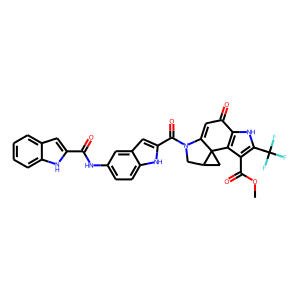

In [6]:
#Define Query molecule
smiles = "COC(=O)c1c(C(F)(F)F)[nH]c2c1C13CC1CN(C(=O)c1cc4cc(NC(=O)c5cc6ccccc6[nH]5)ccc4[nH]1)C3=CC2=O"
Query = rdkit.Chem.MolFromSmiles(smiles)
#Depict Query molecule
rdkit.Chem.Draw.MolToImage(Query, includeAtomNumbers=True)

Now, that is a pretty complex molecule! As we said before, this already has quite a low $IC_{50}$, but, ¿how could we make it even lower? We can try to  find similar molecules to see if one of them has better $IC_{50}$. To do this, we upload the cannonical smiles to [SwisSimilarity](http://www.swisssimilarity.ch/?), selecting "Combined - ChEMBL (activity<10µM)". Once we get the results, we export the data as "ScreeningResults.csv" and save it in the same folder as this NoteBook to continue:

In [7]:
#Fist, we get the smiles for all the molecules associated with our initial target, CHEMBL1856
swiss_table = pd.read_csv('./ScreeningResults.csv', delimiter=';')
raw_database = swiss_table.set_axis(['ChemblID','Score','Smile'], axis=1)
PandasTools.AddMoleculeColumnToFrame(raw_database, smilesCol='Smile')

For similarity analysis, we have to, first, select a "fingerprinting" method that will let us compare the proteins. There are two main methods:
* Molecular ACCess System (MACCS) fingerprints, also termed MACCS structural keys, consist of 166 predefined structural fragments. Each position queries the presence or absence of one particular structural fragment or key.
*  Morgan Fingerprints, also called circular fingerprints, are based on the homonymous algorithm, in which each bit corresponds to the circular environment of each atom, and the number of neighboring bonds and atoms is set by the radius. The length is thus variable

Each of this methods has its own advantages and disadvantages, so we will combine both for maximum accuracy.

In [8]:
#We build databases for the two methods
MACCSDatabase = raw_database.ROMol.apply(MACCSkeys.GenMACCSKeys)
MorganDatabase = rdFingerprintGenerator.GetFPs(raw_database["ROMol"].tolist())

In [9]:
#And prepare the queries:
MorganQuery = rdFingerprintGenerator.GetFPs([Query])[0]
MACCQuery = MACCSkeys.GenMACCSKeys(Query)

Now, we have some queries and databases to search them for. But, ¿how can we evaluate the accuracy of the match? Here, we propose the usage of two common similarity measures: [the Tanimoto index and the Dice index](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-015-0069-3).

In [10]:
# We calculate this indices both for the MACCS fingerprints
raw_database["Tanimoto (MACCS)"] = rdkit.DataStructs.BulkTanimotoSimilarity(MACCQuery, MACCSDatabase)
raw_database["Dice (MACCS)"] = rdkit.DataStructs.BulkDiceSimilarity(MACCQuery, MACCSDatabase)
# And for the morgan fingerprint too
raw_database["Tanimoto (Morgan)"] = rdkit.DataStructs.BulkTanimotoSimilarity(MorganQuery, MorganDatabase)
raw_database["Dice (Morgan)"] = rdkit.DataStructs.BulkDiceSimilarity(MorganQuery, MorganDatabase)

We can now proceed to analyse our results! For instance, we could plot the Tanimoto similarity for the MACCS fingerprints versus those for the Morgan Fingerprints. The best molecules would be those with higher overall values, i.e. those closer to the top right corner. So:

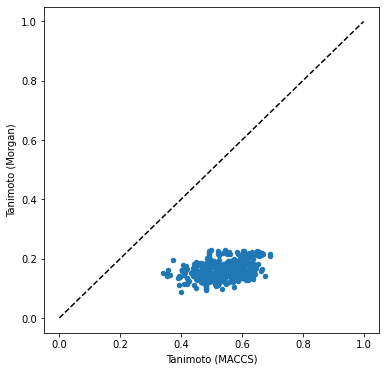

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))
raw_database.plot("Tanimoto (MACCS)", "Tanimoto (Morgan)", kind="scatter", ax=ax)
ax.plot([0, 1], [0, 1], "k--")
ax.set_xlabel("Tanimoto (MACCS)")
ax.set_ylabel("Tanimoto (Morgan)")
fig;

We can see there is not much variability in the morgan fingerprints, with MACCS fingerprints bringing just a bit more info. That is weird! Lets check the distribution histograms to see if that is indeed the case:

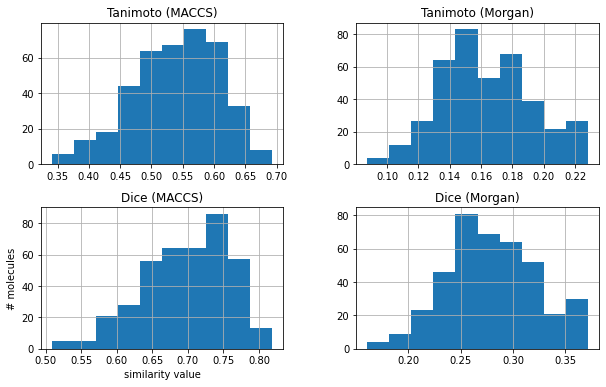

In [12]:
fig, axes = plt.subplots(figsize=(10, 6), nrows=2, ncols=2)
raw_database.hist(["Tanimoto (MACCS)"], ax=axes[0, 0])
raw_database.hist(["Tanimoto (Morgan)"], ax=axes[0, 1])
raw_database.hist(["Dice (MACCS)"], ax=axes[1, 0])
raw_database.hist(["Dice (Morgan)"], ax=axes[1, 1])
axes[1, 0].set_xlabel("similarity value")
axes[1, 0].set_ylabel("# molecules")
fig;

Seeing the histograms, we can't say for sure; it seems like MACCS has indeed a bit more variability, but meh. We can also directly compare Tanimoto and Dice similarities for the two fingerprints.

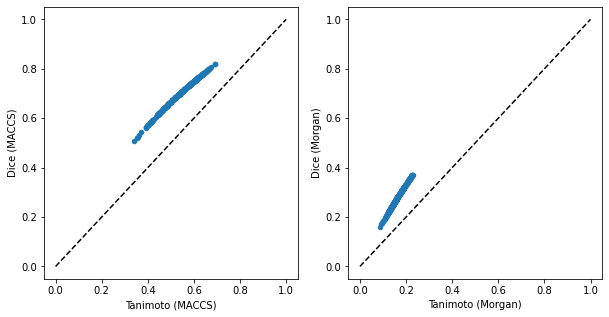

In [13]:
fig, axes = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)

raw_database.plot("Tanimoto (MACCS)", "Dice (MACCS)", kind="scatter", ax=axes[0])
axes[0].plot([0, 1], [0, 1], "k--")
axes[0].set_xlabel("Tanimoto (MACCS)")
axes[0].set_ylabel("Dice (MACCS)")

raw_database.plot("Tanimoto (Morgan)", "Dice (Morgan)", kind="scatter", ax=axes[1])
axes[1].plot([0, 1], [0, 1], "k--")
axes[1].set_xlabel("Tanimoto (Morgan)")
axes[1].set_ylabel("Dice (Morgan)")

fig;

There is indeed difference between the two methods, both in variance and in average values.

Finally, we may select molecules which are pretty similar to our starting molecule. Lets see the average values for our parameters:

In [14]:
raw_database.describe()

,Score,Tanimoto (MACCS),Dice (MACCS),Tanimoto (Morgan),Dice (Morgan)
count,399.000000,399.000000,399.000000,399.000000,399.000000
mean,0.006852,0.539287,0.697946,0.163126,0.279435
std,0.002403,0.070169,0.060605,0.028957,0.042704
min,0.004000,0.340909,0.508475,0.087302,0.160584
25%,0.005000,0.488088,0.655994,0.142857,0.250000
50%,0.006000,0.543210,0.704000,0.160305,0.276316
75%,0.008000,0.597392,0.747959,0.182609,0.308824
max,0.020000,0.693333,0.818898,0.228070,0.371429


As we can see, the simmilarity scores are pretty small, but this is to be expected when selecting "Combined - ChEMBL (activity<10µM)" in ENSEMBL, as it takes two methods (electroshape and fingerprint) which are quite different. For our Tanimoto and Dice metrics, we can see that all metrics including MACCS yield way better values than those used with the Morgan fingerprint, and those with Dice show better results than those with Tanimoto. Thus, we use "dice_maccs" as our parameter, and set the cutoff to 0.725 (with a length of ~150 elements as we were told to have) and save the data for the next Assignment.

In [15]:
raw_databasefilter = raw_database.loc[raw_database['Dice (MACCS)'].astype('float') > 0.725]
len(raw_databasefilter. index)

156

In [16]:
#We could thus proceed to save, but... see the next section!!
#raw_database.to_csv('./SimilarityAnalysisFinasteride.csv')

## Check for already approved drugs

That is all very well if we dont have any previously approved drugs, but what if the state-of-the-art is currently more advanced and we indeed have a good target that is selective and has a good $IC_{50}$? Lets see...

In [17]:
#We specify we want approved drugs that target CHEMBL1856
mechanism_url = "https://www.ebi.ac.uk/chembl/api/data/mechanism?target_chembl_id__exact=CHEMBL1856"
#And get data from the URL
mechanism_components = requests.get(mechanism_url, headers={"Accept":"application/json"}).json()
#Translate it to table
mechanism_table = pd.DataFrame.from_dict(mechanism_components['mechanisms'])[['molecule_chembl_id', 'max_phase']]
mechanism_table #And print

,molecule_chembl_id,max_phase
0,CHEMBL710,4


¡Oh! So **there is** one approved drug! As we can see in the [report card](https://www.ebi.ac.uk/chembl/compound_report_card/CHEMBL710/), this drug is finasteride, which is consistent with the info displayed in the report's sources. Lets see if we can find some simmilar drugs in SwissSimilarity (re-making 1.2)...

This is the Canonical Smiles for Finasteride:
    
    CHEMBL710: CC(C)(C)NC(=O)[C@H]1CC[C@H]2[C@@H]3CC[C@H]4NC(=O)C=C[C@]4(C)[C@H]3CC[C@]12C
    
We can depict it:

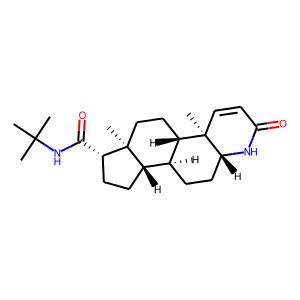

In [3]:
smiles = "CC(C)(C)NC(=O)[C@H]1CC[C@H]2[C@@H]3CC[C@H]4NC(=O)C=C[C@]4(C)[C@H]3CC[C@]12C"
Query = rdkit.Chem.MolFromSmiles(smiles)
rdkit.Chem.Draw.MolToImage(Query, includeAtomNumbers=True)

And then import the reports from SwissSimilarity and generate the desired metrics:

In [4]:
swiss_table_fns = pd.read_csv('./ScreeningResultsFinasteride.csv', delimiter=';', 
                              names =('ChemblID','Score','Smile'))
PandasTools.AddMoleculeColumnToFrame(swiss_table_fns, smilesCol='Smile')

In [5]:
MACCSDatabase = swiss_table_fns.ROMol.apply(MACCSkeys.GenMACCSKeys)
MorganDatabase = rdFingerprintGenerator.GetFPs(swiss_table_fns["ROMol"].tolist())
MorganQuery = rdFingerprintGenerator.GetFPs([Query])[0]
MACCQuery = MACCSkeys.GenMACCSKeys(Query)

In [6]:
swiss_table_fns["Tanimoto (MACCS)"] = rdkit.DataStructs.BulkTanimotoSimilarity(MACCQuery, MACCSDatabase)
swiss_table_fns["Dice (MACCS)"] = rdkit.DataStructs.BulkDiceSimilarity(MACCQuery, MACCSDatabase)
swiss_table_fns["Tanimoto (Morgan)"] = rdkit.DataStructs.BulkTanimotoSimilarity(MorganQuery, MorganDatabase)
swiss_table_fns["Dice (Morgan)"] = rdkit.DataStructs.BulkDiceSimilarity(MorganQuery, MorganDatabase)

To select the best compounds, lets once again analyze their simmilarity scores:

In [7]:
swiss_table_fns.describe()

,Score,Tanimoto (MACCS),Dice (MACCS),Tanimoto (Morgan),Dice (Morgan)
count,400.000000,400.000000,400.000000,400.000000,400.000000
mean,0.055978,0.482113,0.640505,0.157272,0.258770
std,0.099914,0.130162,0.115564,0.108950,0.140409
min,0.025000,0.205128,0.340426,0.035294,0.068182
25%,0.027750,0.388682,0.559785,0.093458,0.170940
50%,0.030000,0.450806,0.621456,0.113636,0.204082
75%,0.038000,0.600000,0.750000,0.172580,0.294359
max,0.998000,1.000000,1.000000,1.000000,1.000000


Hum! Interesting. Even though we used the same method, the simmilarity scores are way higher! Tanimoto and Dice indexes, are, in general, a bit worse, but still acceptable; and, as before, values are Dice > Tanimoto and MACCS > Tanimoto; so, we filter by Dice MACCS:

In [23]:
swiss_table_fns_filter = swiss_table_fns.loc[swiss_table_fns['Dice (MACCS)'].astype('float') > 0.625]
len(swiss_table_fns_filter. index)

194

This is great! We can thus proceed to save this new database, instead of the old one, given that finasteride is already known to be target-selective. We remove the ROMol column since:
a) they are images
b) they can be easily generated
c) they hugely increase DB size

In [24]:
swiss_table_fns_filter.drop('ROMol', axis=1).to_csv('./SimilarityAnalysisFinasteride.csv', index=False)